In [1]:
import tensorflow as tf
# List all physical GPU devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled for:", physical_devices[0])
    except RuntimeError as e:
        # Memory growth must be set before initializing GPUs
        print("Error setting memory growth:", e)
else:
    print("No GPU devices found.")

No GPU devices found.


In [2]:
with tf.device('/cpu:0'):
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Lambda
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    from tensorflow.keras.losses import MeanSquaredError
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.optimizers import Nadam
    import matplotlib.pyplot as plt
    from tensorflow.keras import backend as K
    from tensorflow.keras import layers


: 

In [4]:
with tf.device('/cpu:0'):

    #from google.colab import drive
    #drive.mount('/content/drive')

    # Load the numpy array X from the compressed .npz file
    X_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_train_CI3.npz')
    X_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_test_CI3.npz')

    Y_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_train_CI3.npz')
    Y_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_test_CI3.npz')


    X_train =X_train['X']
    X_test  =X_test ['X']

    Y_train =Y_train['X']
    Y_test  =Y_test ['X']


In [23]:

with tf.device('/cpu:0'):

    shape = 64*64*3

    def build_vae(input_shape, layer_neurons, latent_dim):
        # Input for the encoder
        inputs = tf.keras.Input(shape=(input_shape,))

        # Encoder architecture
        x = inputs
        for neurons in layer_neurons:
            x = layers.Dense(neurons, activation='relu', kernel_initializer='he_normal')(x)
        z_mean = layers.Dense(latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

        # Reparameterization trick
        def sampling(args):
            z_mean, z_log_var = args
            epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

        # Encoder model
        encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

        # Input for the decoder
        decoder_inputs = tf.keras.Input(shape=(latent_dim,))

        # Decoder architecture
        x = decoder_inputs
        for neurons in reversed(layer_neurons):
            x = layers.Dense(neurons, activation='relu', kernel_initializer='he_normal')(x)
        outputs = layers.Dense(input_shape, activation='sigmoid')(x)

        # Decoder model
        decoder = Model(decoder_inputs, outputs, name='decoder')

        return encoder, decoder


    # Instantiate the VAE model
    class VAE(tf.keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")


        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,

            ]

        def call(self, inputs):
            z_mean, z_log_var, z = self.encoder(inputs)
            reconstructed = self.decoder(z)
            '''cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=reconstructed, labels=inputs)
            reconstruction_loss = -tf.reduce_sum(cross_ent, axis=1)
            log2pi = tf.math.log(2. * np.pi)
            #normal pdf
            logpz = tf.reduce_sum(-0.5 * ((z - 0.) ** 2.), axis=1)
            logqz_x=tf.reduce_sum(-.5 * ((z - z_mean) ** 2. * tf.exp(-z_log_var) + z_log_var + log2pi),axis=1)
            kl_loss = logpz - logqz_x
            total_loss=-tf.reduce_mean(reconstruction_loss + 0.01* kl_loss)'''

            reconstruction_loss=tf.reduce_mean(tf.keras.losses.mse(inputs, reconstructed))
            #reconstruction_loss = tf.reduce_mean(  tf.keras.losses.binary_crossentropy(inputs, reconstructed)  )
            #reconstruction_loss *= shape
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.1
            total_loss = reconstruction_loss + 0.0001*kl_loss
            

            self.add_loss(total_loss)
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)



            return reconstructed


In [24]:
hidden_layer_configs = [
        [1024, 512],#best result from crossvalidation
    ]

latent_dim = [256]#best result from crossvalidation

encoder , decoder = build_vae(shape,hidden_layer_configs[0],latent_dim[0] )
vae = VAE(encoder, decoder, name='vae')


    

# Compile the model
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])
X_train = X_train.reshape(-1, 64*64*3)
X_test = X_test.reshape(-1, 64*64*3)

# Train the VAE
history = vae.fit(X_train, X_train, epochs=25,validation_data=(X_test, X_test) ,batch_size=32,verbose=1)

Epoch 1/25
269/269 [==============================] - 4s 13ms/step - total_loss: 0.8055 - reconstruction_loss: 0.7925 - kl_loss: 123.3969 - val_total_loss: 0.7140 - val_reconstruction_loss: 0.7041 - val_kl_loss: 111.7002
Epoch 2/25
269/269 [==============================] - 3s 12ms/step - total_loss: 0.6879 - reconstruction_loss: 0.6769 - kl_loss: 104.6729 - val_total_loss: 0.6758 - val_reconstruction_loss: 0.6674 - val_kl_loss: 97.5300
Epoch 3/25
269/269 [==============================] - 3s 12ms/step - total_loss: 0.6637 - reconstruction_loss: 0.6543 - kl_loss: 95.9643 - val_total_loss: 0.6622 - val_reconstruction_loss: 0.6543 - val_kl_loss: 92.5207
Epoch 4/25
269/269 [==============================] - 3s 12ms/step - total_loss: 0.6516 - reconstruction_loss: 0.6418 - kl_loss: 91.0189 - val_total_loss: 0.6535 - val_reconstruction_loss: 0.6461 - val_kl_loss: 88.2739
Epoch 5/25
269/269 [==============================] - 3s 12ms/step - total_loss: 0.6449 - reconstruction_loss: 0.6362 - k

48/48 [==============================] - 1s 22ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5087125716113583..2.2269362853620303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2945280855723384..2.7359609068821142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6091079593181568..2.7868633690341227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.652134554049642..2.2948062348980414].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5762888074871928..2.0037297768427225].


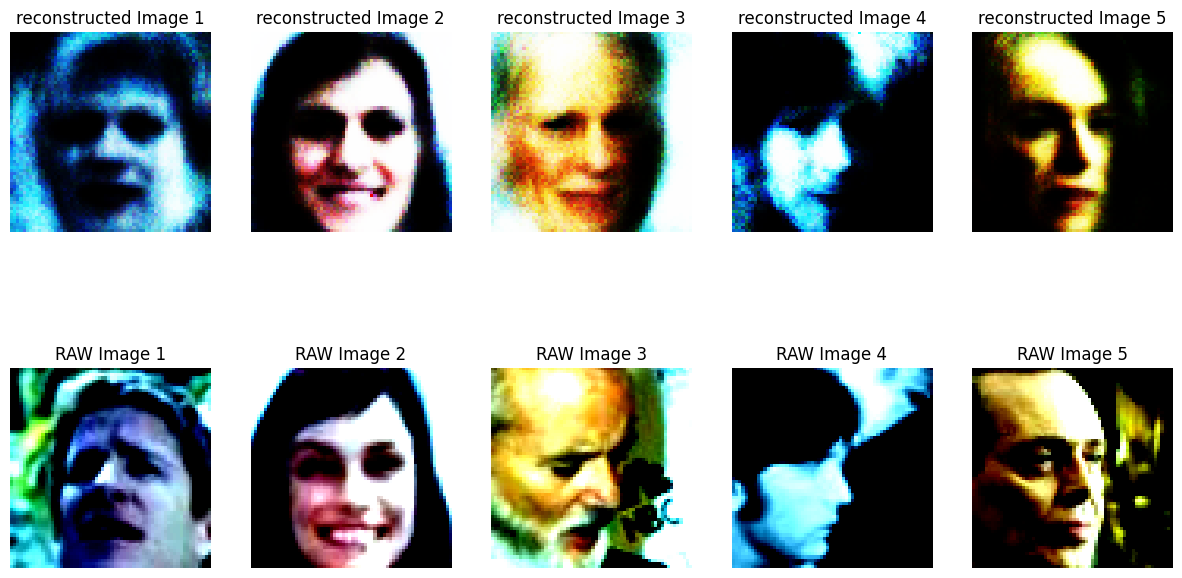

In [25]:
import matplotlib.pyplot as plt
with tf.device('/cpu:0'):
    
    ss= vae.predict(X_test.reshape(-1,64*64*3))
    
    ss= ss.reshape(-1,64,64,3)
    # Plot 5 random images from the X array
    plt.figure(figsize=(15, 8))  
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(ss[i]) 
        plt.axis('off')  
        plt.title(f"reconstructed Image {i+1}")
        
        plt.subplot(2, 5, i+6)  
        plt.imshow(X_test[i].reshape(64,64,3)) 
        plt.axis('off')  
        plt.title(f"RAW Image {i+1}")
        
        
    
    
    plt.show()

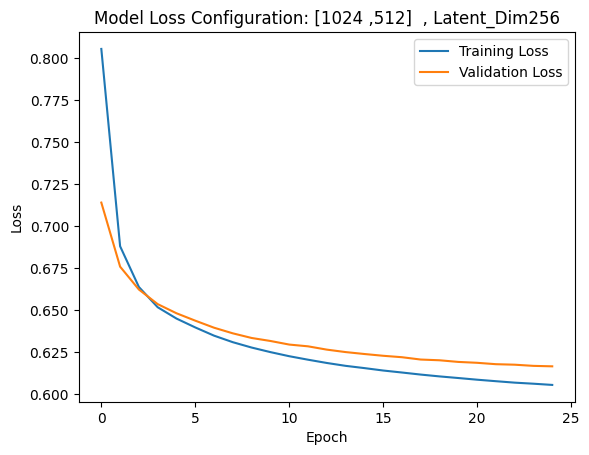

In [26]:
loss = history.history['total_loss']
val_accuracy = history.history['val_total_loss']
plt.plot(loss, label='Training Loss')
plt.plot(val_accuracy, label='Validation Loss')
plt.title(f"Model Loss Configuration: [1024 ,512]  , Latent_Dim{latent_dim[0]}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [33]:
#Accuracy
def accuracy(y_test1, y_pred1):
    y_pred1 = np.array(y_pred1)
    counter = 0
    for i in range(len(y_pred1)):
      if (y_pred1[i] == y_test1[i]):
        counter += 1
    accuracy = counter / len(y_pred1)
    accuracy *= 100
    return accuracy

from sklearn.metrics import confusion_matrix

# visualizing the results
def visualize_results(y_test,y_predict):
    #class_names = [folder for folder in os.listdir(r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories") if os.path.isdir(os.path.join(r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories", folder))]
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_predict)

    # Calculate accuracy for each class
    class_accuracies = (cm.diagonal() / cm.sum(axis=1)) * 100

    # Display class-wise accuracy
    #classes = [f"Class {i}" for i in range(len(class_accuracies))]  # Replace with actual class names if available
    array = np.arange(0, 100)
    # Plot the accuracies
    plt.figure(figsize=(15, 5))
    plt.bar(array, class_accuracies, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Class-Wise Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 100)  # Accuracy is in percentage
    plt.tight_layout()
    plt.show()

In [28]:
#ecludian distance classifer "NN"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
#import seaborn as sns
with tf.device('/cpu:0'):
    feature_vector_test = encoder.predict(X_test.reshape(-1,64*64*3))
    feature_vector_train =encoder.predict(X_train.reshape(-1,64*64*3))


269/269 [==============================] - 3s 12ms/step


In [29]:
feature_vector_test  = np.array (feature_vector_test)
feature_vector_train = np.array(feature_vector_train)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(feature_vector_train[2], Y_train)#X_train.reshape(X_train.shape[0], -1)
predictions = knn.predict(feature_vector_test[2])
accuracy(Y_test, predictions)

24.422442244224424

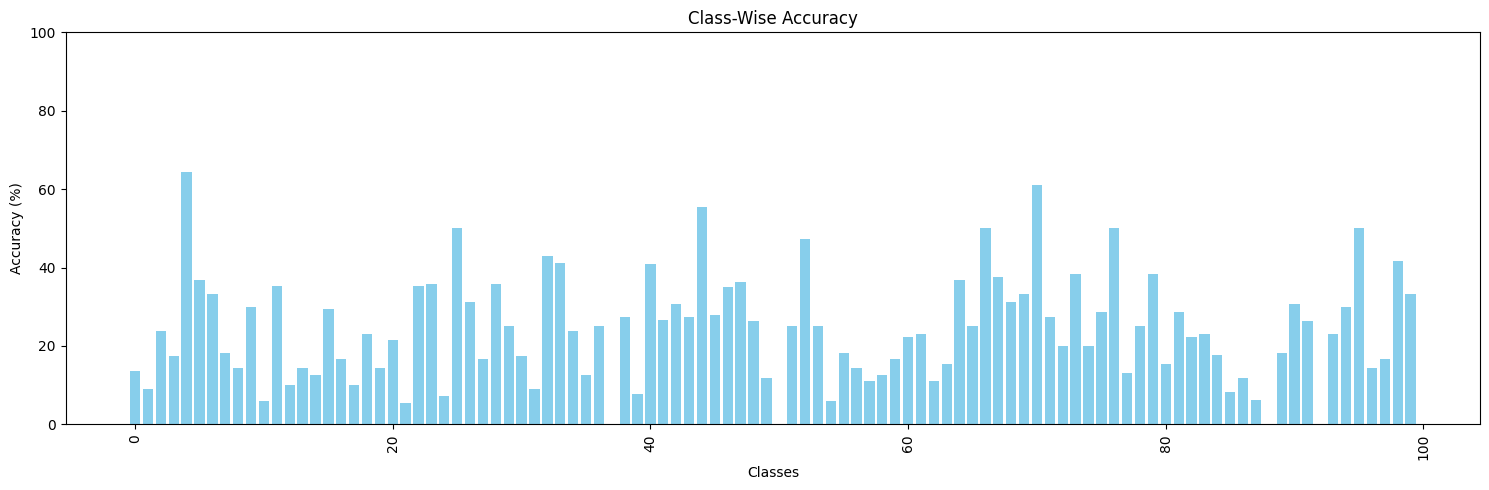

In [34]:
visualize_results(Y_test, predictions)